In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

# import networkx as nx


root_path = os.path.abspath(os.path.join(os.path.abspath(""), "../.."))

In [2]:
f = open(f'{root_path}/code/02_global_overview_piQTLs/PPI_similarity_network_order.txt', 'r')
PPI_network_order = [ line.strip() for line in f.readlines() ]
f.close()

In [3]:
gene_loc = pd.read_csv(f'{root_path}/data/genome_annotations/genes_by_strain/S288C_genes.csv')

In [4]:
def get_locus(x, gene_loc):
    try :
        return gene_loc[gene_loc['Gene'] == x]['Locus'].values[0]
    except:
        return np.nan

PPI_list = pd.read_csv(f'{root_path}/data/pipeline/PPI_reference_barcodes.csv')
PPI_list['PPI_bait'] =  [ PPI_list['PPI'][idx].split('_')[0] for idx in PPI_list.index ]
PPI_list['PPI_prey'] =  [ PPI_list['PPI'][idx].split('_')[1] for idx in PPI_list.index ]

PPI_list['PPI_bait'] =  [ PPI_list['PPI'][idx].split('_')[0] for idx in PPI_list.index ]
PPI_list['PPI_prey'] =  [ PPI_list['PPI'][idx].split('_')[1] for idx in PPI_list.index ]

PPI_list['Locus_bait'] = PPI_list['PPI_bait'].apply(get_locus, args=(gene_loc,))
PPI_list['Locus_prey'] = PPI_list['PPI_prey'].apply(get_locus, args=(gene_loc,))

In [5]:
PPI_list

,well_position,ppi,N-index,S-index,N_barcode,S_barcode,PPI,PPI_bait,PPI_prey,Locus_bait,Locus_prey
0,A1,GTR1:SLM4,N701,S501,TCGCCTTA,TAGATCGC,GTR1_SLM4,GTR1,SLM4,YML121W,YBR077C
1,A2,SNA4:GTR2,N702,S501,CTAGTACG,TAGATCGC,SNA4_GTR2,SNA4,GTR2,YDL123W,YGR163W
2,A3,ERG11:HYR1,N703,S501,TTCTGCCT,TAGATCGC,ERG11_HYR1,ERG11,HYR1,YHR007C,YIR037W
3,A4,DHH1:LSM3,N704,S501,GCTCAGGA,TAGATCGC,DHH1_LSM3,DHH1,LSM3,YDL160C,YLR438C-A
4,A5,MID2:PIN2,N705,S501,AGGAGTCC,TAGATCGC,MID2_PIN2,MID2,PIN2,YLR332W,YOR104W
...,...,...,...,...,...,...,...,...,...,...,...
57,H4,MID2:MAM33,N704,S508,GCTCAGGA,CTAAGCCT,MID2_MAM33,MID2,MAM33,YLR332W,YIL070C
58,H5,MID2:WSC2,N705,S508,AGGAGTCC,CTAAGCCT,MID2_WSC2,MID2,WSC2,YLR332W,YNL283C
59,H7,HNM1:TPO2,N707,S508,GTAGAGAG,CTAAGCCT,HNM1_TPO2,HNM1,TPO2,YGL077C,YGR138C
60,H8,ALO1:ADE17,N708,S508,CCTCTCTG,CTAAGCCT,ALO1_ADE17,ALO1,ADE17,YML086C,YMR120C


In [6]:
PPIs_separated = []
for PPI in PPI_list['Locus_bait']:
    PPIs_separated.append(PPI)
for PPI in PPI_list['Locus_prey']:
    PPIs_separated.append(PPI)
f = open(f'{root_path}/data/safe-data/attributes/all_PPIs_in_piQTLs.txt', 'w')
f.write('Locus\tPPI\n')
for PPI in set(PPIs_separated):
    f.write(f'{PPI}\t0.05\n')
f.close()


In [7]:
def set_correlation_score(idx, table):
    z_score = table['-log_pval'][idx]
    if z_score >= 4 : #### Here you can play with this threshold
        return 1
    else :
        return 0

In [8]:
#### Here I'm building the manhatthan similarity matrix across all the conditions
folder_path = f'{root_path}/data/piQTLs/piQTL_original/'
all_MTX = []
MTX_correlation_matrix = []
for PPI in tqdm(PPI_list['PPI']):
    for DRUG in ['noDrug', '5.FC', 'Fluconazole', 'Metformin', 'Trifluoperazine'] :
        MTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_minus_ref.csv'))
        MTX['SNP_ID'] = [ f'CHR{MTX["CHR"][idx]}_{MTX["SNP"][idx]}' for idx in MTX.index ]
        MTX['-log_pval'] = -np.log10(MTX['P'])

        MTX[f'{PPI}_MTX_{DRUG}'] = [ set_correlation_score(idx, MTX) for idx in MTX.index ]
        all_MTX.append(MTX)
        MTX_correlation_matrix.append(MTX[['SNP_ID', f'{PPI}_MTX_{DRUG}']].set_index(['SNP_ID']).T)

MTX_DF = pd.concat(MTX_correlation_matrix)

  0%|          | 0/62 [00:00<?, ?it/s]

100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


In [9]:
#### You need to remove the MTX-specific piQTLs before performing the other steps
MTX_QTLs = pd.read_csv(f'{root_path}/results/05_piQTL_tables/MTX_specific_QTLs_with_genome_annotations.csv')
MTX_QTLs['SNP_ID'] = [ f'CHR{MTX_QTLs["Chr"][idx]}_{MTX_QTLs["SNP"][idx]}' for idx in MTX_QTLs.index ]
MTX_piQTLs = list(MTX_QTLs['SNP_ID'])
MTX_piQTLs.append('CHR15_10435')
MTX_piQTLs.append('CHR15_10455')
MTX_piQTLs.append('CHR15_10456')
MTX_piQTLs.append('CHR15_10468')

In [10]:
piQTL_QTLs = MTX_DF[[ col for col in MTX_DF.columns if col not in list(MTX_QTLs['SNP_ID'])]].reset_index().rename(columns={'index':'Condition'})

In [11]:
piQTL_QTLs

SNP_ID,Condition,CHR1_1,CHR1_2,CHR1_3,CHR1_4,CHR1_5,CHR1_6,CHR1_7,CHR1_8,CHR1_9,...,CHR17_12045,CHR17_12046,CHR17_12047,CHR17_12048,CHR17_12049,CHR17_12050,CHR17_12051,CHR17_12052,CHR17_12053,CHR17_12054
0,GTR1_SLM4_MTX_noDrug,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,GTR1_SLM4_MTX_5.FC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,GTR1_SLM4_MTX_Fluconazole,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,GTR1_SLM4_MTX_Metformin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,GTR1_SLM4_MTX_Trifluoperazine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,noPPI_reference_MTX_noDrug,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
306,noPPI_reference_MTX_5.FC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
307,noPPI_reference_MTX_Fluconazole,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
308,noPPI_reference_MTX_Metformin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: xlabel='SNP_ID'>

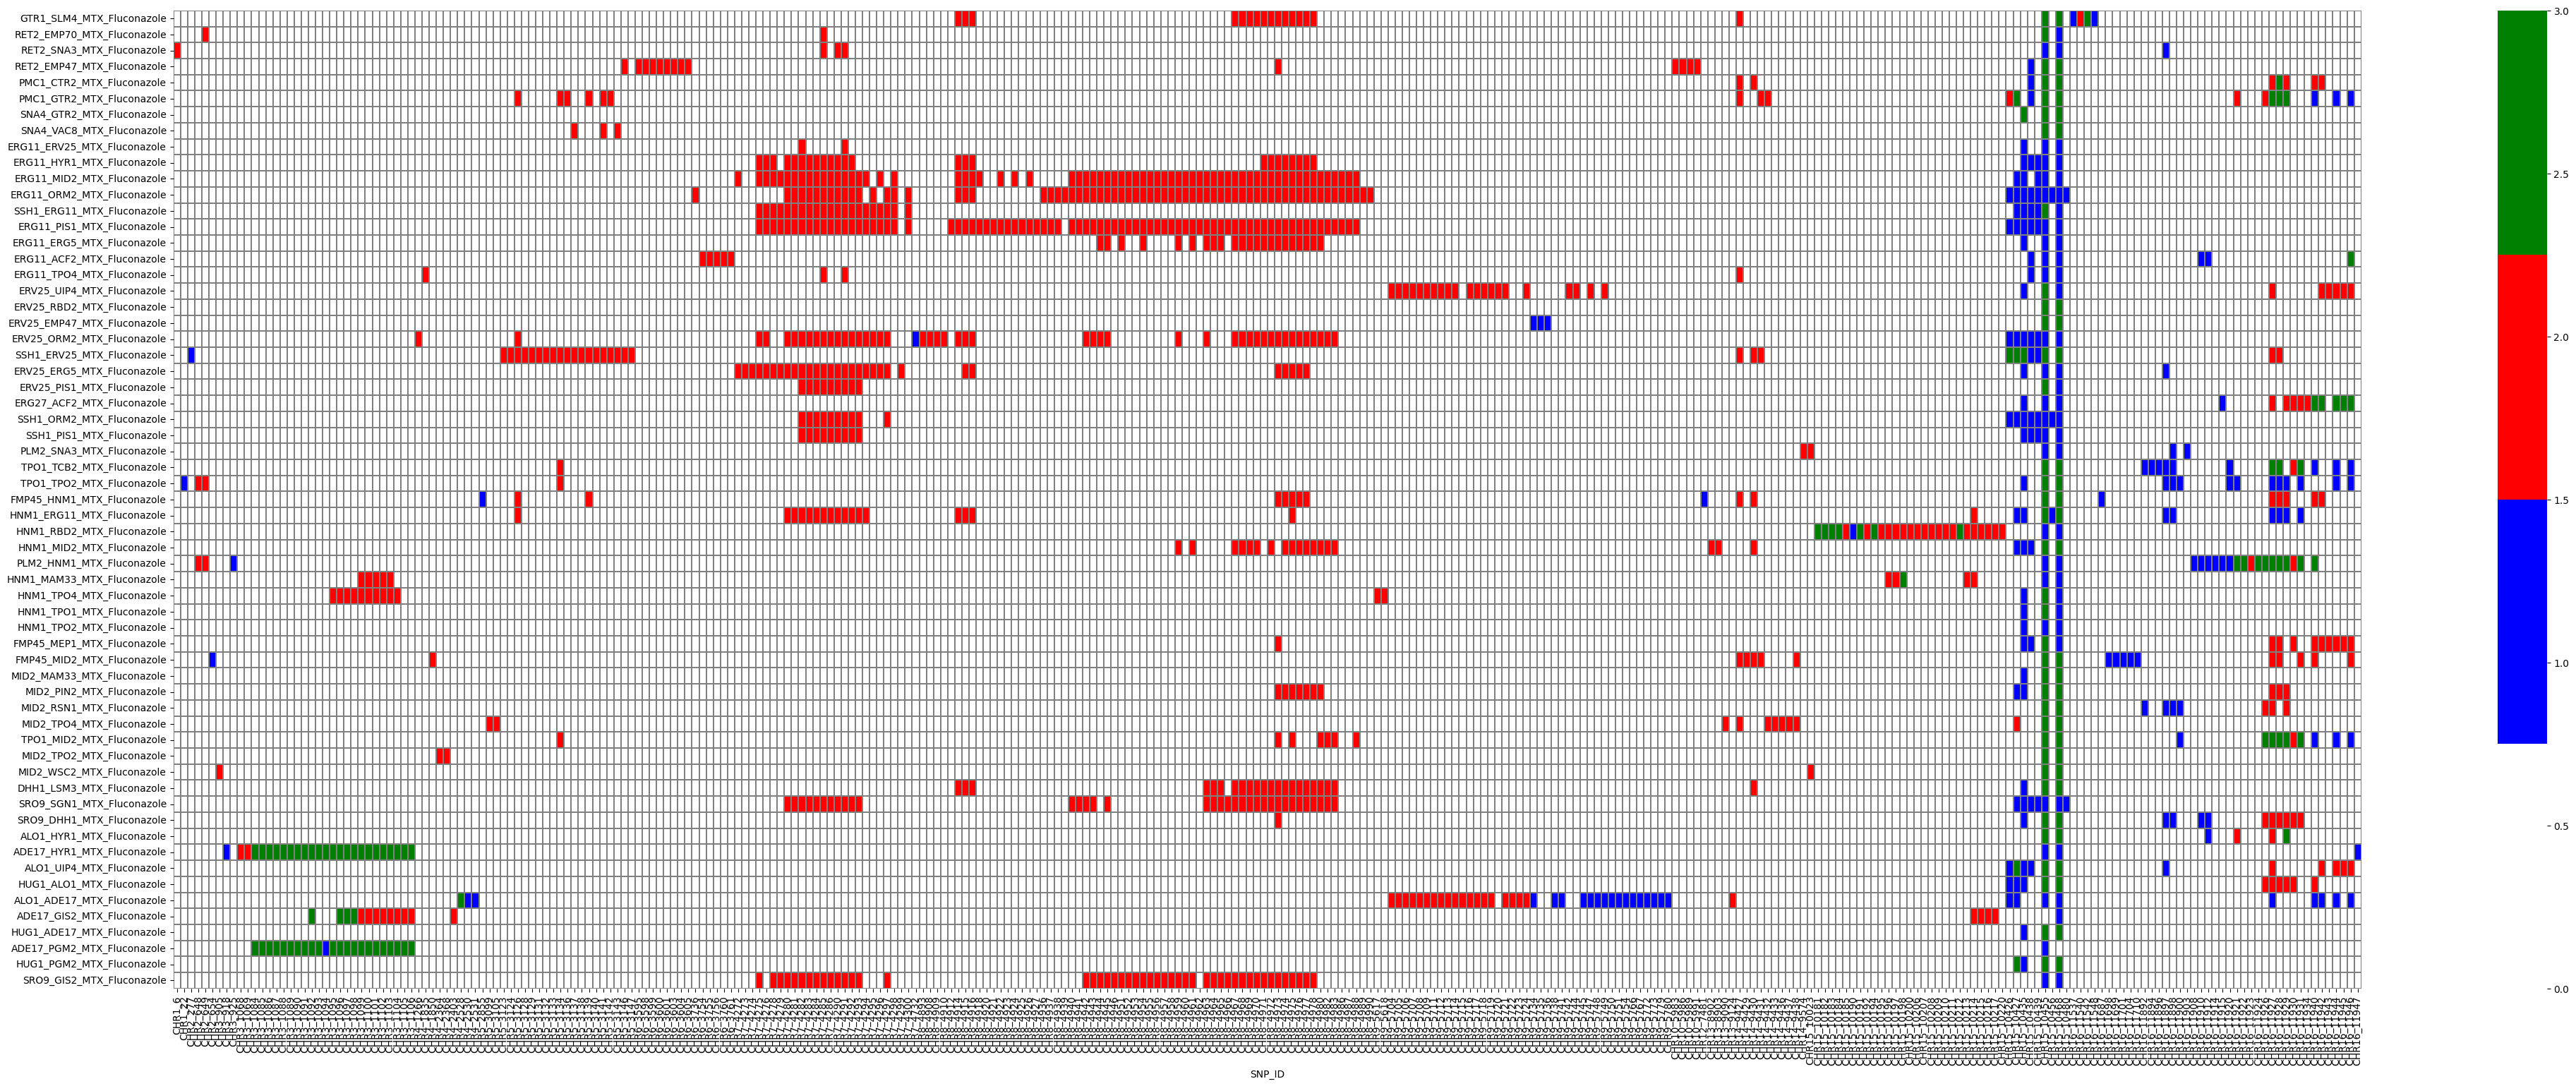

In [12]:
DRUG1 = 'Fluconazole' 
PPI_order_DRUG1 = []
for PPI in PPI_network_order:
    if PPI in PPI_list['ppi'].values :
        PPI_order_DRUG1.append(f"{PPI.replace(':','_')}_MTX_{DRUG1}")
    else : 
        PPI_order_DRUG1.append(f"{PPI.split(':')[1]}:{PPI.split(':')[0]}_MTX_{DRUG1}".replace(':','_'))

Fluc = piQTL_QTLs[piQTL_QTLs['Condition'].isin(PPI_order_DRUG1)].reset_index(drop=True)
Fluc['Condition'] = Fluc['Condition'].astype(pd.CategoricalDtype(ordered=True, categories=PPI_order_DRUG1))
Fluc = Fluc.replace(1,2)
Fluc = Fluc.sort_values('Condition').set_index('Condition')

DRUG2 = 'noDrug' 
PPI_order_DRUG2 = []
for PPI in PPI_network_order:
    if PPI in PPI_list['ppi'].values :
        PPI_order_DRUG2.append(f"{PPI.replace(':','_')}_MTX_{DRUG2}")
    else : 
        PPI_order_DRUG2.append(f"{PPI.split(':')[1]}:{PPI.split(':')[0]}_MTX_{DRUG2}".replace(':','_'))
        
noDrug = piQTL_QTLs[piQTL_QTLs['Condition'].isin(PPI_order_DRUG2)].reset_index(drop=True)
noDrug['Condition'] = noDrug['Condition'].astype(pd.CategoricalDtype(ordered=True, categories=PPI_order_DRUG2))
# noDrug = noDrug.replace(1,-1)
noDrug = noDrug.sort_values('Condition').set_index('Condition')

Fluc_noDrug = pd.concat([Fluc, noDrug])
piQTL_only = pd.DataFrame(Fluc_noDrug.sum(axis=0) != 0, columns=['piQTL']).reset_index('SNP_ID')
piQTL_only = piQTL_only[piQTL_only['piQTL'] == True]


Fluc_noDrug = Fluc_noDrug.reset_index()

A = Fluc_noDrug[Fluc_noDrug['Condition'].str.contains(DRUG1)][piQTL_only['SNP_ID']]

B = Fluc_noDrug[Fluc_noDrug['Condition'].str.contains('noDrug')][piQTL_only['SNP_ID']].reset_index(drop=True)

f = plt.figure(figsize=(50,18))
ALL = A.add(B)
ALL.index =  PPI_order_DRUG1
# ALL.to_csv(f'../results/08_piQTL_heatmaps/{DRUG1}_heatmap.csv')
sns.heatmap(ALL, xticklabels=True, yticklabels=True, cmap=['white', 'blue', 'red', 'green'], linewidths=0.2, linecolor='grey')


In [13]:
pariwise_comparison_snps = []
ALL_piQTLs = ALL
# ALL_piQTLs = ALL.replace(2,1).replace(3,1)
for SNP in tqdm(ALL_piQTLs.columns) :
    for i in range(len(ALL_piQTLs.index)):
        for j in range(i+1, len(ALL_piQTLs.index)):
            PPI1 = ALL_piQTLs.index[i]
            PPI2 = ALL_piQTLs.index[j]

            SNP1 = ALL_piQTLs[SNP][PPI1]
            SNP2 = ALL_piQTLs[SNP][PPI2]
            if SNP1 == SNP2 : 
                if (SNP1 == 0) and (SNP2 == 0):
                    res = 0
                else : 
                    res = 1
            else : 
                res = 0
            pariwise_comparison_snps.append([PPI1.replace(f'_MTX_{DRUG1}', '').replace('_', ':'), PPI2.replace(f'_MTX_{DRUG1}', '').replace('_', ':'), SNP, res])

  0%|          | 0/308 [00:00<?, ?it/s]

100%|██████████| 308/308 [00:03<00:00, 77.92it/s]


In [14]:
results = pd.DataFrame(pariwise_comparison_snps, columns=['PPI1', 'PPI2', 'SNP', 'identity'])
overlapping_peaks = results.groupby('SNP').sum().reset_index()

# stacked = results.groupby(['PPI1', 'PPI2']).sum().stack()
stacked = results.groupby(['PPI1', 'PPI2']).sum()
# PPI_overlapping_peaks = stacked.reset_index().rename(columns={0:'overlapping_peaks'}).drop(columns=['level_2']).sort_values('overlapping_peaks')
PPI_overlapping_peaks = stacked.reset_index().rename(columns={"identity": "overlapping_peaks"}).drop(columns=['SNP']).sort_values('overlapping_peaks')

In [15]:
PPI_overlapping_peaks

,PPI1,PPI2,overlapping_peaks
1108,MID2:TPO4,SRO9:GIS2,0
327,ERG11:ORM2,MID2:WSC2,0
326,ERG11:ORM2,MID2:TPO4,0
325,ERG11:ORM2,MID2:TPO2,0
324,ERG11:ORM2,MID2:RSN1,0
...,...,...,...
282,ERG11:MID2,SRO9:GIS2,48
379,ERG11:PIS1,SRO9:GIS2,49
250,ERG11:MID2,ERG11:ORM2,61
300,ERG11:ORM2,ERG11:PIS1,69


In [16]:
def get_bin(x):
    if x >=4 :
        return 4
    else : 
        return x 

/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


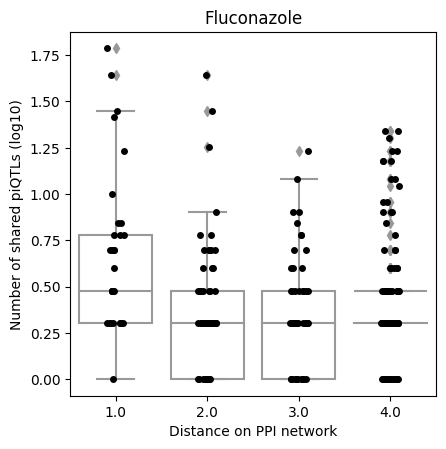

In [17]:
df = pd.read_csv(f'{root_path}/results/07_network_analysis/distance_matrix_piQTLs.csv')

stacked = df.set_index('PPI').stack()
PPI_distance = stacked.reset_index().rename(columns={'PPI':'PPI1','level_1':'PPI2', 0:'distance'})
PPI_distance = PPI_distance[PPI_distance['PPI1'] != PPI_distance['PPI2']]

RES = PPI_overlapping_peaks.merge(PPI_distance, on=['PPI1', 'PPI2'])
RES['overlapping_peaks'] = RES['overlapping_peaks'].replace(0,0.5)
RES['bin'] = RES['distance'].apply(get_bin)


RES = PPI_overlapping_peaks.merge(PPI_distance, on=['PPI1', 'PPI2'])
RES['bin'] = RES['distance'].apply(get_bin)

# RES = RES[RES['overlapping_peaks'] >= 1]
CM = 1/2.54 # centimeters in inches
f = plt.figure(figsize=(12*CM, 12*CM))
sns.boxplot(x=RES['bin'], y=np.log10(RES['overlapping_peaks']), color='white')
sns.stripplot(x=RES['bin'], y=np.log10(RES['overlapping_peaks']), color='black')
plt.ylabel('Number of shared piQTLs (log10)')
plt.xlabel('Distance on PPI network')
plt.title(DRUG1)

plt.savefig(f'{root_path}/figures/supp_figures/{DRUG1}_PPI_distance_vs_overlapping_piQTLs.png', format='png', dpi=300)
plt.savefig(f'{root_path}/figures/supp_figures/{DRUG1}_PPI_distance_vs_overlapping_piQTLs.eps', format='eps', dpi=300)